In [61]:
#data manipulation
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette('colorblind')
%matplotlib inline

#NLP lib
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')
from wordcloud import WordCloud

Introducing channels that we will be analysing

In [4]:
ch_df = pd.read_csv('channel_df.csv')

In [5]:
ch_df

,Unnamed: 0,channel_title,channel_desc,channel_view,channel_sub,channel_video,channel_playlistId
0,0,Jenny Damm,NaN,796465,5730,175,UUwLs3Ldbl1Ox-fvupUq7ipA
1,1,PointyFloppy,Adventure of border collies with pointy and fl...,2004,9,58,UUSPfJ89aYsRhpDSnZ0vaFCg
2,2,absoluteDogs,This is the official YouTube channel of Tom an...,1017985,47600,234,UUrz5NqpcLxpiy1Wm_ksEV3g
3,3,McCann Dogs Agility,"Kayl McCann is a dog trainer, who has been a m...",165303,4580,129,UUULyOKD5Y9QTKFDikg2UDgw
4,4,Iwona Golab,🌎Agility Worldwide Coach 🏆World Championship M...,210681,1440,251,UUxXnIktVdXrSFCE8u1D-26w
5,5,Fanny Gott,Clicker training videos,1466307,7130,413,UUqw_HGVtWKcd-owWODwcQsg
6,6,Dogs That,Our DogsThat YouTube Channel is brought to you...,2122473,43600,290,UUC17PDLl8y1dP2BRV5vuseg
7,7,Peak Performer,NaN,300353,1550,488,UUEaf-PDONb_nhyNRmVw9_nA
8,8,Dog Training by Kikopup,Professional dog training videos created by wo...,41556897,358000,595,UU-qnqaajTk6bfs3UZuue6IQ
9,9,OneMindDogs,OneMind Dogs is a dog and agility training met...,995279,6380,368,UUMF2E-huI3T7meqJBU-olZg


<AxesSubplot:title={'center':'Dog Training Channel Ranked by Subscribers'}, xlabel='channel_title', ylabel='channel_video'>

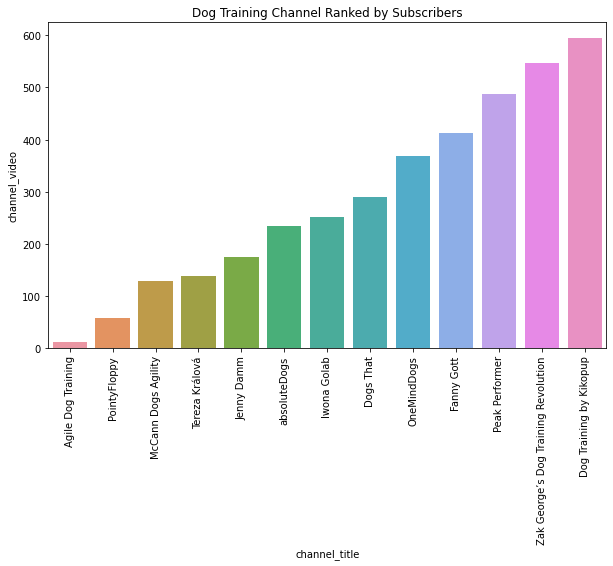

In [19]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
plt.title('Dog Training Channel Ranked by Subscribers')
sns.barplot(x='channel_title',y='channel_video',data = ch_df.sort_values('channel_video'))

<Figure size 720x432 with 0 Axes>

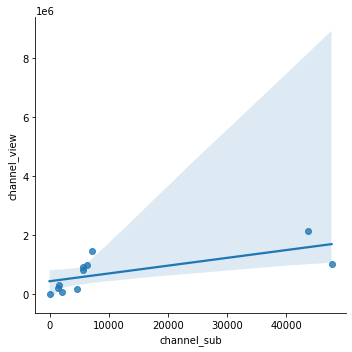

In [17]:
#excluding the top two outliers - we will investigate the channel sub vs channel views
plt.figure(figsize=(10,6))
sns.lmplot(x='channel_sub', y='channel_view', data = ch_df.sort_values(by='channel_sub',ascending=True)[0:-2])

In [21]:
df = pd.read_csv('video_df.csv')

In [22]:
df.shape

(3698, 13)

#### Check for empty values

In [23]:
df.isnull().sum() / len(df['video_id']) * 100

video_id          0.000000
channelTitle      0.000000
title             0.000000
description      12.330990
tags             27.068686
publishedAt       0.000000
duration          0.000000
definition        0.000000
caption           0.000000
viewCount         0.000000
likeCount         0.081125
favoriteCount     0.000000
commentCount      0.676041
dtype: float64

In [24]:
df.isnull().sum()

video_id            0
channelTitle        0
title               0
description       456
tags             1001
publishedAt         0
duration            0
definition          0
caption             0
viewCount           0
likeCount           3
favoriteCount       0
commentCount       25
dtype: int64

<AxesSubplot:>

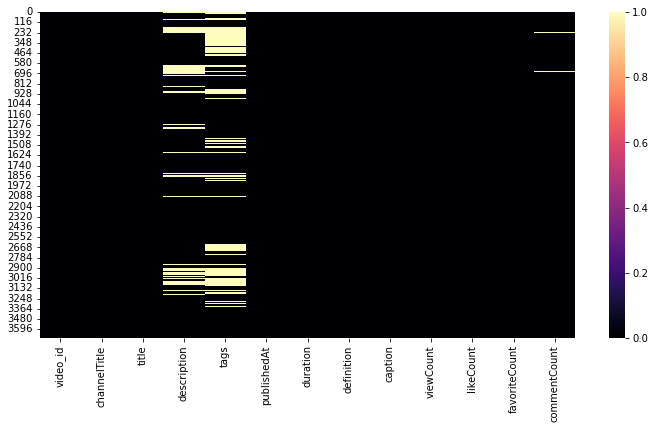

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(),cmap='magma')

Since this data is acquired through API, we can fill in empty values with a specific words like "No description", "0 tags"
But let's investigate no likeCount and no commentCount - as these should be nulls too

In [26]:
df[df['likeCount'].isnull()]

,video_id,channelTitle,title,description,tags,publishedAt,duration,definition,caption,viewCount,likeCount,favoriteCount,commentCount
2399,6INllFeO19k,Dog Training by Kikopup,Dog Training seminar in Venice Italy,Visit our website: http://dogmantics.com/\nBuy...,"['dog training', 'professional dog trainer', '...",2012-05-25T17:46:14Z,PT2M33S,sd,False,6827,NaN,0,28.0
3026,MANZ9_b__g0,Tereza Králová,High´s first competition :-),NaN,NaN,2019-12-27T16:11:38Z,PT1M27S,hd,False,7171,NaN,0,3.0
3109,LEvUD2GPGYY,Tereza Králová,Flame_Czech Agility Championship 2012,Just Flame Perla z Polabí & Tereza Králová\n1s...,"['Flame', 'MČR2012']",2012-11-14T16:09:19Z,PT2M39S,sd,False,1945,NaN,0,0.0


In [27]:
df[df['commentCount'].isnull()]

,video_id,channelTitle,title,description,tags,publishedAt,duration,definition,caption,viewCount,likeCount,favoriteCount,commentCount
15,qYuqGotfdzc,Jenny Damm,"Ziv's - training 1: Running contacts, crate ga...",(Version without music) This is Ziv's first tr...,['iMovie'],2021-08-26T08:52:52Z,PT5M15S,sd,False,361,13.0,0,NaN
148,5asS8VFZ27g,Jenny Damm,Garden training 2009,Jenny Damm is training with a friends and her ...,"['jenny', 'damm', 'border', 'collie', 'dogs', ...",2009-10-09T13:04:11Z,PT9M7S,sd,False,4685,21.0,0,NaN
232,QZ-35pWgSg8,PointyFloppy,Agility Training EP1. Action camera fun run,NaN,NaN,2021-07-11T15:12:20Z,PT47S,hd,False,17,0.0,0,NaN
576,zyAHbqivIds,McCann Dogs Agility,Slyce - preparation for WAO - Feb 2012,Kayl McCann & Slyce - These are drills we prac...,"['dog', 'agility', 'sport', 'puppies', 'jumpin...",2012-03-03T00:48:15Z,PT1M47S,hd,False,525,3.0,0,NaN
577,GxY-ryYqRdA,McCann Dogs Agility,Funkee Monkee - Preparation for WAO Feb 2012,Kayl McCann with Slyce & Funkee Monkee - Membe...,"['dog', 'agility', 'sport', 'puppies', 'jumpin...",2012-03-03T00:47:42Z,PT1M51S,hd,False,748,2.0,0,NaN
674,-GFbW6HdTuM,Iwona Golab,"Applause, RC, 16 months",NaN,NaN,2016-06-05T05:23:17Z,PT31S,hd,False,2454,12.0,0,NaN
675,x5f93BPV6wA,Iwona Golab,Applause training 01 May,NaN,"['agility', 'training', 'iwona golab', 'applau...",2016-05-01T21:26:21Z,PT45S,hd,False,867,9.0,0,NaN
676,PvhRRxcBT-s,Iwona Golab,Applause 2 strides dogwalk,Always impatient Applause :-) Why bother with ...,"['running contacts', 'dogwalk', 'agility', 'rc...",2016-04-26T13:56:39Z,PT17S,hd,False,1318,15.0,0,NaN
677,WPu49iVmdU8,Iwona Golab,Applause a frame,NaN,NaN,2016-04-09T11:27:57Z,PT10S,hd,False,674,2.0,0,NaN
678,L0Ur0-uO0bQ,Iwona Golab,"Applause - Absolutely simple, beautiful and ma...",NaN,"['agility', 'iwona golab']",2016-04-08T17:52:24Z,PT1M53S,hd,False,1288,14.0,0,NaN


They are videos where likes and comments are turned off. So we will replace these with 0 (int) to correct data type

In [28]:
df['likeCount'].fillna(int(0),inplace=True)

In [29]:
df['commentCount'].fillna(int(0),inplace=True)

In [30]:
df.isnull().sum()

video_id            0
channelTitle        0
title               0
description       456
tags             1001
publishedAt         0
duration            0
definition          0
caption             0
viewCount           0
likeCount           0
favoriteCount       0
commentCount        0
dtype: int64

In [31]:
df['description'].fillna('No Description',inplace=True)

In [32]:
df['tags'].fillna('0',inplace=True)

In [33]:
df.isnull().sum()

video_id         0
channelTitle     0
title            0
description      0
tags             0
publishedAt      0
duration         0
definition       0
caption          0
viewCount        0
likeCount        0
favoriteCount    0
commentCount     0
dtype: int64

<AxesSubplot:>

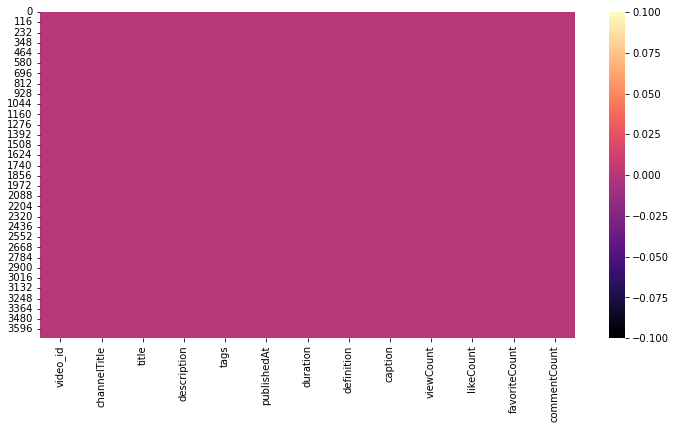

In [34]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(),cmap='magma')

All data's are filled!

#### Now I need to check data types

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   video_id       3698 non-null   object 
 1   channelTitle   3698 non-null   object 
 2   title          3698 non-null   object 
 3   description    3698 non-null   object 
 4   tags           3698 non-null   object 
 5   publishedAt    3698 non-null   object 
 6   duration       3698 non-null   object 
 7   definition     3698 non-null   object 
 8   caption        3698 non-null   bool   
 9   viewCount      3698 non-null   int64  
 10  likeCount      3698 non-null   float64
 11  favoriteCount  3698 non-null   int64  
 12  commentCount   3698 non-null   float64
dtypes: bool(1), float64(2), int64(2), object(8)
memory usage: 350.4+ KB


tags should be counted, publishedAt should be date, duration should be time, likeCount and commentCount should be int.

In [36]:
df['likeCount'] = df['likeCount'].apply(np.int64)

In [37]:
df['commentCount'] = df['commentCount'].apply(np.int64)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       3698 non-null   object
 1   channelTitle   3698 non-null   object
 2   title          3698 non-null   object
 3   description    3698 non-null   object
 4   tags           3698 non-null   object
 5   publishedAt    3698 non-null   object
 6   duration       3698 non-null   object
 7   definition     3698 non-null   object
 8   caption        3698 non-null   bool  
 9   viewCount      3698 non-null   int64 
 10  likeCount      3698 non-null   int64 
 11  favoriteCount  3698 non-null   int64 
 12  commentCount   3698 non-null   int64 
dtypes: bool(1), int64(4), object(8)
memory usage: 350.4+ KB


In [42]:
df['publishedAt'].head(5)

0   2022-05-01 05:22:37
1   2022-04-26 15:11:04
2   2022-03-30 10:28:18
3   2022-03-16 07:01:08
4   2022-03-10 22:17:25
Name: publishedAt, dtype: datetime64[ns]

In [43]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

In [45]:
#df['publishedAt'] = df['publishedAt'].map(lambda x: pd.to_datetime(x, yearfirst=True).tz_convert('Asia/Bangkok'))

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       3698 non-null   object        
 1   channelTitle   3698 non-null   object        
 2   title          3698 non-null   object        
 3   description    3698 non-null   object        
 4   tags           3698 non-null   object        
 5   publishedAt    3698 non-null   datetime64[ns]
 6   duration       3698 non-null   object        
 7   definition     3698 non-null   object        
 8   caption        3698 non-null   bool          
 9   viewCount      3698 non-null   int64         
 10  likeCount      3698 non-null   int64         
 11  favoriteCount  3698 non-null   int64         
 12  commentCount   3698 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(4), object(7)
memory usage: 350.4+ KB


Note: Datetime should be posted depending on their own timezones

In [47]:
df['duration']

0    PT5M59S
1     PT3M9S
2    PT4M26S
3    PT1M50S
4    PT3M24S
Name: duration, dtype: object

In [48]:
import isodate
dur = isodate.parse_duration('PT5M59S')
print(dur.total_seconds())

ModuleNotFoundError: No module named 'isodate'

need to change to proper duration time

#### Sample plots

Investigate relationship between title length and view counts

<Figure size 864x432 with 0 Axes>

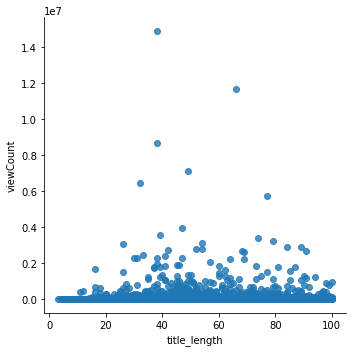

In [117]:
#title length vs view
df['title_length'] = df['title'].apply(lambda x: len(x)) #move to feature engineering part

plt.figure(figsize=(12,6))
sns.lmplot(x='title_length',y='viewCount',data=df)

comment count vs view count

<Figure size 864x432 with 0 Axes>

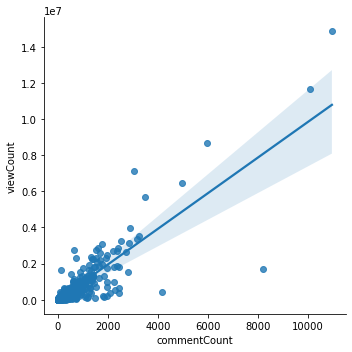

In [115]:
plt.figure(figsize=(12,6))
sns.lmplot(x='commentCount',y='viewCount',data=df)

observation: seems like there is a trend between view and comment - possibly due to youtube algorithm

<Figure size 864x432 with 0 Axes>

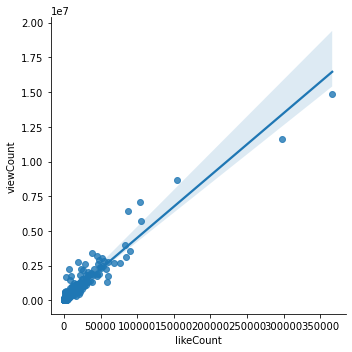

In [116]:
plt.figure(figsize=(12,6))
sns.lmplot(x='likeCount',y='viewCount',data=df)

Investigating differences in published time, but has to be based on channel location - in reality should check subscribers location as well to match that

In [121]:
my_channel = df[df['channelTitle'] == 'PointyFloppy']

In [146]:
my_channel['published_hr'] = my_channel['publishedAt'].apply(lambda x : x.hour) #ignore warning?

C:\Users\smile\AppData\Local\Temp\ipykernel_26352\1029569742.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_channel['published_hr'] = my_channel['publishedAt'].apply(lambda x : x.hour)


<AxesSubplot:xlabel='published_hr', ylabel='Count'>

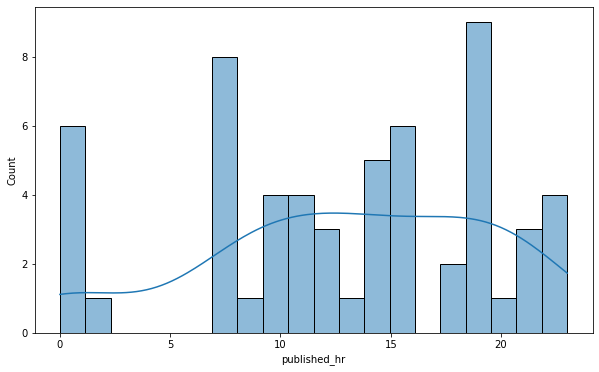

In [155]:
plt.figure(figsize=(10,6))
sns.histplot(data=my_channel, x="published_hr",bins=20,kde=True)

<Figure size 864x432 with 0 Axes>

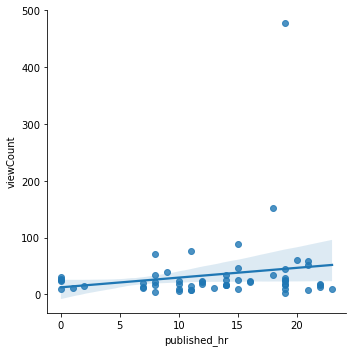

In [156]:
plt.figure(figsize=(12,6))
sns.lmplot(x='published_hr',y='viewCount',data=my_channel)

May not be clear but we can explore other timezones - or match with other thai dog channels to see if uploading in the evening will get more views

#### Go back all data

In [159]:
df

,video_id,channelTitle,title,description,tags,publishedAt,duration,definition,caption,viewCount,likeCount,favoriteCount,commentCount,title_length
0,YOaTYVydeH4,Jenny Damm,Training a Tamas Traj course at Torvalla Arena...,NaN,NaN,2022-05-01 12:22:37+07:00,PT5M59S,hd,False,1247,22,0,0,73
1,pFHvzNWqetU,Jenny Damm,Azta's four winning runs + final at Gåsahoppet...,NaN,NaN,2022-04-26 22:11:04+07:00,PT3M9S,hd,False,1302,27,0,1,58
2,5F5s9EsSaIs,Jenny Damm,Jocke course - Training with Azta & Mailiz,NaN,NaN,2022-03-30 17:28:18+07:00,PT4M26S,hd,False,557,23,0,1,42
3,duX57XPjJJg,Jenny Damm,Mailiz trying my new course Lotushallen 210315,NaN,NaN,2022-03-16 14:01:08+07:00,PT1M50S,hd,False,588,15,0,0,48
4,1YRoVzPLwpM,Jenny Damm,"Lisa and My - RC training - soft turns, 220309",NaN,NaN,2022-03-11 05:17:25+07:00,PT3M24S,hd,False,419,14,0,3,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,1D_16qpO21Y,Zak George’s Dog Training Revolution,How To PLAY With Two Dogs at Once,http://www.facebook.com/TheZakGeorge The BEST ...,"['dog', 'training', 'frisbee', 'zak', 'george'...",2011-10-25 16:33:38+07:00,PT5M43S,hd,False,41944,816,0,83,33
3694,xq27e5hp4_w,Zak George’s Dog Training Revolution,Dog Training: A conversation with Dr. Ian Dunbar,Please visit http://www.dogstardaily.com\r\n\r...,"['zak', 'george', 'ian', 'dunbar', 'dog', 'tra...",2011-03-17 21:14:47+07:00,PT30M43S,sd,False,49393,827,0,129,48
3695,O-ziOPzsBHk,Zak George’s Dog Training Revolution,INSANE FRISBEE DOGS!,http://www.facebook.com/TheZakGeorge The BEST ...,"['Frisbee', 'dogs', 'disc', 'trick', 'dog', 't...",2010-01-06 05:11:54+07:00,PT4M6S,sd,False,294647,1240,0,213,20
3696,nF1Wb_94_ec,Zak George’s Dog Training Revolution,How to Teach Your Dog to Back Up and Weave Bac...,The Zak George Project:\r\nhttp://blogs.discov...,"['How', 'to', 'train', 'dog', 'tricks', 'zak',...",2009-07-14 11:36:57+07:00,PT2M1S,sd,False,154466,1277,0,147,70


In [67]:
type()

pandas._libs.tslibs.timestamps.Timestamp

In [71]:
#create a column for published day of the week
df['publishedDay'] = df['publishedAt'].apply(lambda x : x.strftime("%A"))

In [75]:
#change format of duration column
df['duration_sec'] = df['duration'].apply(lambda x : isodate.parse_duration(x))
df['duration_sec'] = df['duration_sec'].astype('timedelta64[s]')

In [81]:
df['duration_min'] = df['duration_sec'].apply(lambda x : round(x/60))

In [84]:
df.head(5)

,video_id,channelTitle,title,description,tags,publishedAt,duration,definition,caption,viewCount,likeCount,favoriteCount,commentCount,publishedDay,duration_sec,duration_min
0,YOaTYVydeH4,Jenny Damm,Training a Tamas Traj course at Torvalla Arena...,No Description,0,2022-05-01 05:22:37,PT5M59S,hd,False,1247,22,0,0,Sunday,359.0,6
1,pFHvzNWqetU,Jenny Damm,Azta's four winning runs + final at Gåsahoppet...,No Description,0,2022-04-26 15:11:04,PT3M9S,hd,False,1302,27,0,1,Tuesday,189.0,3
2,5F5s9EsSaIs,Jenny Damm,Jocke course - Training with Azta & Mailiz,No Description,0,2022-03-30 10:28:18,PT4M26S,hd,False,557,23,0,1,Wednesday,266.0,4
3,duX57XPjJJg,Jenny Damm,Mailiz trying my new course Lotushallen 210315,No Description,0,2022-03-16 07:01:08,PT1M50S,hd,False,588,15,0,0,Wednesday,110.0,2
4,1YRoVzPLwpM,Jenny Damm,"Lisa and My - RC training - soft turns, 220309",No Description,0,2022-03-10 22:17:25,PT3M24S,hd,False,419,14,0,3,Thursday,204.0,3


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3698 entries, 0 to 3697
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   video_id       3698 non-null   object        
 1   channelTitle   3698 non-null   object        
 2   title          3698 non-null   object        
 3   description    3698 non-null   object        
 4   tags           3698 non-null   object        
 5   publishedAt    3698 non-null   datetime64[ns]
 6   duration       3698 non-null   object        
 7   definition     3698 non-null   object        
 8   caption        3698 non-null   bool          
 9   viewCount      3698 non-null   int64         
 10  likeCount      3698 non-null   int64         
 11  favoriteCount  3698 non-null   int64         
 12  commentCount   3698 non-null   int64         
 13  publishedDay   3698 non-null   object        
 14  duration_sec   3698 non-null   float64       
 15  duration_min   3698 n

In [87]:
#feature engineering
#need to count number of tags
#no. of likes and comments per views (1000) maybe
#title character length
#popular words in title characters

In [88]:
#EDA part
#view distribution in each channel
#viewcount vs comment/like
#view to comment ratio or view to like ratio
#video duration matter?
#title length matter?
#wordcloud for title
#worldcloud for comment
#no. of tags - popular tags?
#days in week - note the timezone
#month ?

#things to note
#add more local channels
#positive comments? correlation of comments and title to say which topic is in demand

#can I create a video title suggestion model ?